# Notebook for ZFOURGE CDFS Spectral Luminosity Functions

### Import and setup

In [2]:
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM 

data = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN.csv')
df = pd.DataFrame(data)
df = df[df['Use'] == 1] # 13,299
df = df[df['FKs'] > 0] # 12,676

mag_lim = 25.9 # apparent magnitude limit (same as AB magnitude limit)
redshift_bins = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)] # redshift bins
survey_area = 0.03556 # survey area in square degrees
min_count = 10 # minimum number of galaxies in a bin
lum_bin_edges = np.arange(18, 25, 0.25) # luminosity bin edges
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

### Calculate Luminosity

In [3]:
# Mask AB mag limit
mag_ab = 25 - 2.5*np.log10(df['FKs']) # apparent magnitude -> AB magnitude
mask = (mag_ab <= mag_lim)
fks = df['FKs'].values[mask] # apparent magnitude
z = df['zpk'].values[mask] # redshift

# Flux
f = 0.3631 * fks * 10**-32  # uJy -> W/m^2/Hz

# Flux limit
f_lim = 10 ** ((mag_lim + 56.1) / -2.5) # AB mag -> W/m^2/Hz

# Luminosity Distance
d = cosmo.luminosity_distance(z).to(u.m).value # meters
luminosity = 4 * np.pi * (d**2) * f # m^2 * W/m^2/Hz = W/Hz

### Maximum Observable Volume

calculated for each galaxy

In [4]:
all_data = []

for z_min, z_max in redshift_bins:
    mask = (z >= z_min) & (z < z_max)
    
    lum_bin = np.log10(luminosity)[mask]
    
    # Find the maximum distance for the redshift bin
    dmin = cosmo.comoving_distance(z_min).value # Mpc
    dmax = cosmo.comoving_distance(z_max).value # Mpc
    
    # Find the maximum distance for each source
    dmaxs = np.sqrt(luminosity[mask] / (4*np.pi*f_lim)) # meters
    dmaxs *= 3.241 * 10 ** -23 # meters -> Mpc
    
    # Only use luminosity bins that are possible in the redshift range
    d_mask = dmaxs >= dmin
    dmaxs = dmaxs[d_mask]
    lum_bin = lum_bin[d_mask]
        
    # Limit the distance to the maximum distance
    dmaxs[dmaxs > dmax] = dmax
    
    # Calculate the minimum volume of the redshift bin
    vmin = 4/3 * np.pi * dmin**3 # Mpc^3

    # Calculate the maximum volume of each luminosity bin
    vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3
    
    # Total volume probed accounting for survey area
    vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
    
    all_data.append([vol, lum_bin])

### Luminosity Counts

With luminosity and number count completeness limits

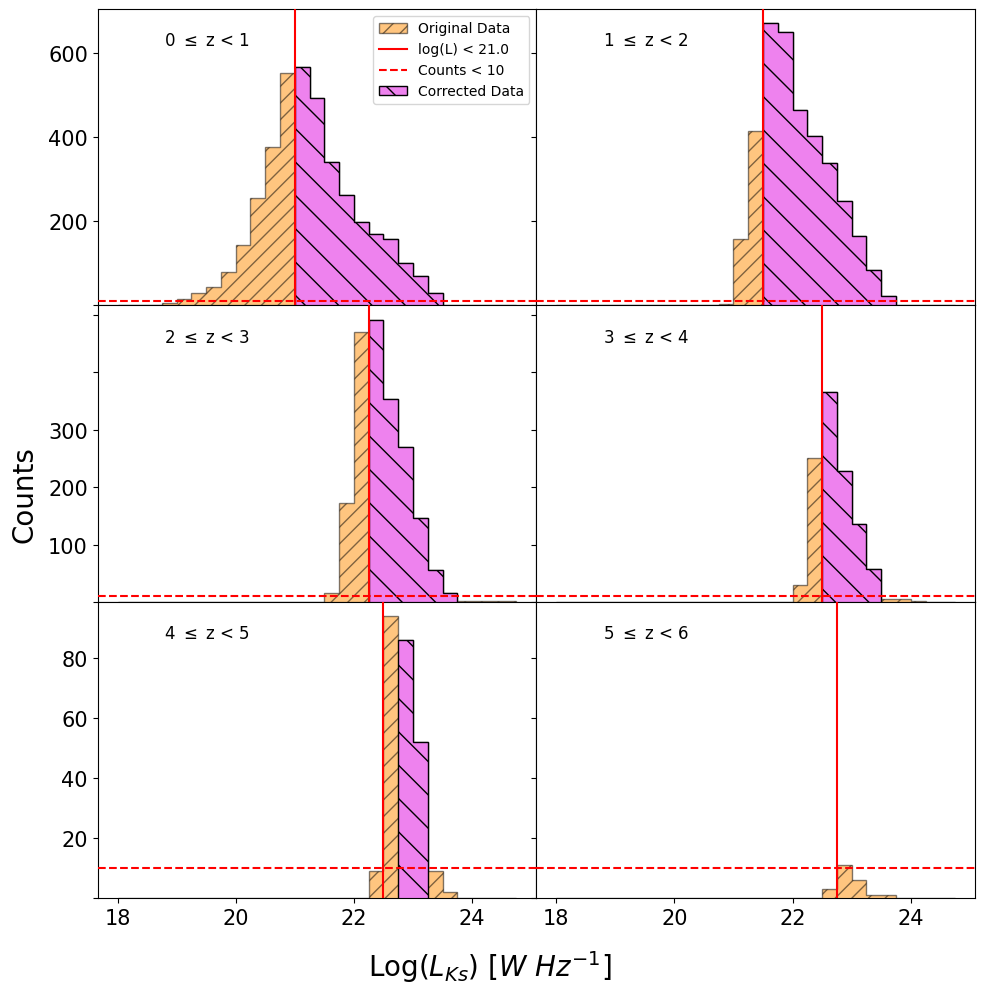

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey='row')
bin_edges = []

for i, (ax, (z_start, z_end), (vol, lum)) in enumerate(zip(axes.flatten(), redshift_bins, all_data)):
    mask_z = (z > z_start) & (z <= z_end)
    
    # Bin the original data per redshift bin
    c, b, _ = ax.hist(np.log10(luminosity)[mask_z], 
        bins=lum_bin_edges, histtype='step', label='Original Data', facecolor='darkorange', edgecolor='black', hatch='//', fill=True, alpha=0.5)
    
    # Luminsity completeness limit
    l_lim = np.where(c == np.max(c))[0][0] # peak
    ax.axvline(b[l_lim], color='red', linestyle='-', label=f'log(L) < {b[l_lim]}', zorder=10)
    mask_l = b[1:] >= b[1:][l_lim-1]
    
    # Minimum limit
    mask_c = c >= min_count
    ax.axhline(min_count, color='red', linestyle='--', label=f'Counts < {min_count}', zorder=10)
    
    # Bin the new data with the same bins
    c, b, _ = ax.hist(lum[lum >= b[l_lim]], bins=b[1:][mask_l & mask_c], histtype='step', label='Corrected Data', facecolor='violet', edgecolor='black', hatch='\\', fill=True)
        
    # Plot the new, corrected data
    ax.set_title(f'{z_start} $\leq$ z < {z_end}', x=0.25, y=0.85, fontsize=12)
    ax.tick_params(axis='both', labelsize=15)
    ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
    if i == 0:
        ax.legend(loc='upper right')
    bin_edges.append(b)

fig.supylabel('Counts', fontsize=20)
fig.supxlabel('Log($L_{Ks}$) [$W\ Hz^{-1}$]', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
# plt.savefig('Spectral Luminosity Counts', dpi=300)
plt.show()

### Vmax calculation

In [6]:
lum_centers, phi, phi_e = [], [], []

# Volume and luminosity are already binned by redshift
for (vol, lum), bin, in zip(all_data, bin_edges):
    if len(bin) < 2:
        continue
    
    delta_log_l = np.diff(bin)[0]
    
    lum_centers_z, phi_z, phi_e_z = [], [], []

    # Bin by luminosity
    for lum_start, lum_end in zip(bin, bin[1:]):
        mask = (lum >= lum_start) & (lum < lum_end)
        vol_lum_bin = vol[mask]
        
        # Calculate the number density
        phi_val = (1 / delta_log_l) * np.sum(1 / vol_lum_bin)
        phi_err = (1 / delta_log_l) * np.sqrt(np.sum(1 / (vol_lum_bin ** 2)))
        
        # Save the luminosity bin and number density
        lum_centers_z.append((lum_start + lum_end) / 2)
        phi_z.append(phi_val)
        phi_e_z.append(phi_err)
    
    # Save the luminosity bins and number densities
    lum_centers.append(lum_centers_z)
    phi.append(phi_z)
    phi_e.append(np.array(phi_e_z))

### Fit Schechter Function

C:\Users\danie\AppData\Local\Temp\ipykernel_15700\3760394336.py:2: RuntimeWarning: overflow encountered in power
  return phi_star * 10 ** (-0.4*(1-alpha)*(M_star-M)) * np.exp(-10.**(-0.4*(M_star-M)))


0 <= z < 1 Function fit:
M_star = 2.41e+01
phi_star = 1.40e-03
alpha = 1.96e+00


1 <= z < 2 Function fit:
M_star = 2.24e+01
phi_star = 1.22e-02
alpha = 9.91e-01


2 <= z < 3 Function fit:
M_star = 2.16e+01
phi_star = 1.54e-02
alpha = -1.45e-01


3 <= z < 4 Function fit:
M_star = 2.19e+01
phi_star = 2.17e-02
alpha = 8.30e-01




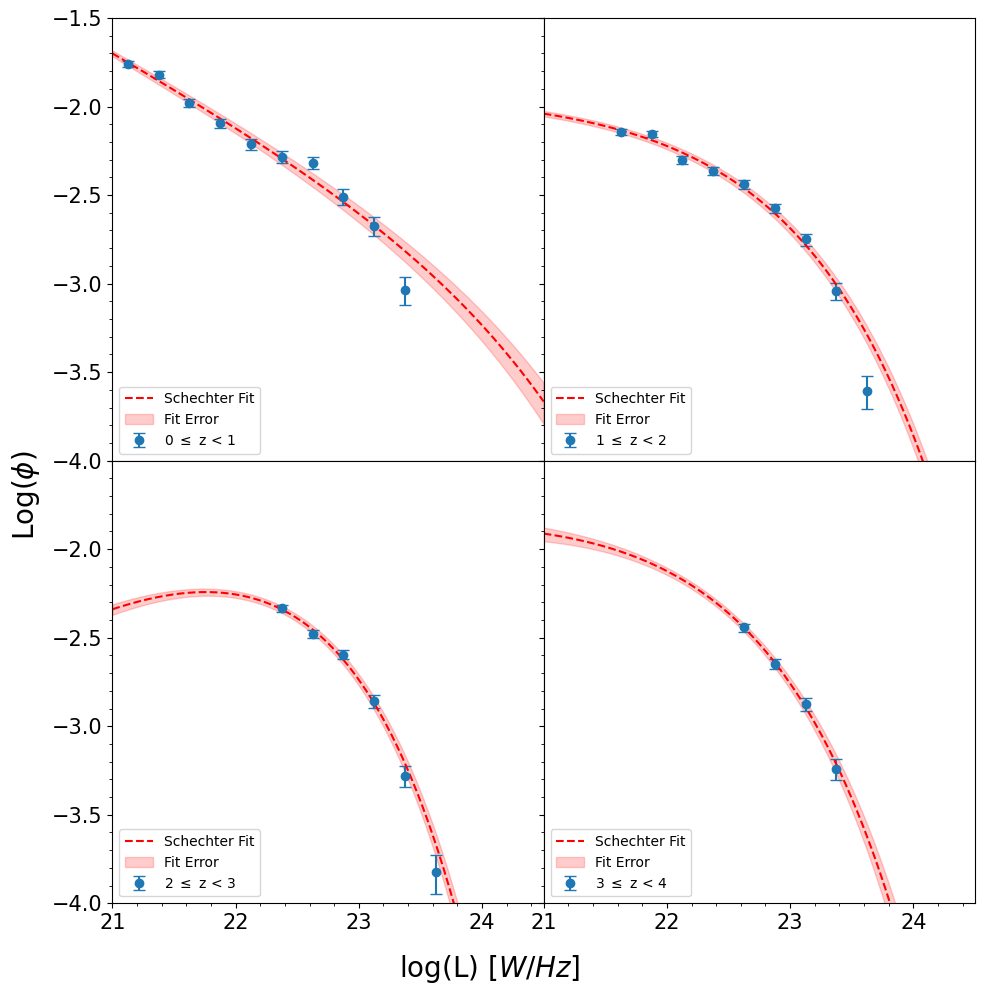

In [7]:
def schechter_luminosity(M, M_star, phi_star, alpha):
    return phi_star * 10 ** (-0.4*(1-alpha)*(M_star-M)) * np.exp(-10.**(-0.4*(M_star-M)))

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):

    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        continue
    
    # Attempt to fit the data
    p0=[lum[0], 0.001, -0.9]
    try:
        params, covars = curve_fit(schechter_luminosity, lum, p, p0=p0, maxfev=10000)
        p_up, _ = curve_fit(schechter_luminosity, lum, p+e, p0=p0, maxfev=10000)
        p_down, _ = curve_fit(schechter_luminosity, lum, p-e, p0=p0, maxfev=10000)
    except RuntimeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Maxfev reached.')
        continue
    except TypeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Params: {len(params)} > data points: {len(lum)}.')
        continue
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'M_star = {params[0]:.2e}')
    print(f'phi_star = {params[1]:.2e}')
    print(f'alpha = {params[2]:.2e}')
    print('\n')
    
    # Plot the data
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    long_lum = np.linspace(21, 24.5, 1000)
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(long_lum, np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
    ax.fill_between(long_lum, 
        np.log10(schechter_luminosity(long_lum, *p_down)),
        np.log10(schechter_luminosity(long_lum, *p_up)), 
        color='red', alpha=0.2, label='Fit Error') 
    ax.legend(loc='lower left')
    ax.tick_params(axis='both', labelsize=15)
    ax.minorticks_on()
    ax.set_xlim(21, 24.5)
    ax.set_ylim(-4, -1.5)
    
axes.flatten()[2].yaxis.get_major_ticks()[-1].label1.set_visible(False)

fig.supxlabel('log(L) [$W/Hz$]', fontsize=20)
fig.supylabel('Log($\phi$)', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
# plt.savefig('Spectral Luminosity Function', dpi=300)
plt.show()